In [122]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [123]:
import requests
import json
from datetime import date, timedelta
from numpy import array
import pandas as pd
import nltk
from nltk.probability import FreqDist
from datetime import date, timedelta, datetime

import re, string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) 

dfnotas = pd.read_csv('NOTAS_EXCELSIOR_ENERO.csv')


[nltk_data] Downloading package stopwords to C:\Users\Diego
[nltk_data]     Esteva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
#ELIMINA NOTAS SIN PVS
nulos=[]

#dfnotas['Número de vistas de página']=dfnotas['Número de vistas de página'].astype(int)
dfnotas = dfnotas.fillna(0)

for i in range(0,len(dfnotas.index)):
    if dfnotas.iloc[i]['Número de vistas de página']==0:
        nulos.append(i)

dfnotas.drop([749], axis=0)

#AUN SE ESTA TRABAJANDO 

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página
0,excelsior,1643350795,Muere Diego Verdaguer en EU a los 70 años,2022-01-28,1:19:55,https://www.excelsior.com.mx/funcion/ultima-ho...,pedro.diaz,_Diego Verdaguer_Amanda Miguel_Famosos,"<p>El cantante argentino<a href=""https://www.e...",437269.0
1,excelsior,1642790787,La dueña del sol se dispone a cobrar por su uso,2022-01-21,13:46:27,https://www.excelsior.com.mx/trending/maria-an...,pedro.diaz,_Trending_España,"<div>\n<p>Aunque parezca una mala broma, una m...",373237.0
2,excelsior,1643353741,Amanda Miguel se despide de Diego Verdaguer: '...,2022-01-28,2:09:01,https://www.excelsior.com.mx/funcion/amanda-mi...,pedro.diaz,Música,"<p>La <a href=""https://www.google.com/search?q...",118515.0
3,excelsior,1641468848,¡Ya abrió! Habilitan registro para vacuna covi...,2022-01-06,6:34:08,https://www.excelsior.com.mx/nacional/abre-reg...,vanessa.campuzano,_Vacuna covid_Covid-19_Variante Ómicron,<p>¿Tienes 40 años o más? Ya puedes <strong>re...,77606.0
4,excelsior,1641680319,"Celebra cumpleaños en la calle con sus perros,...",2022-01-08,17:18:39,https://www.excelsior.com.mx/trending/celebra-...,pedro.diaz,_Trending_Animales_Sociedad,"<p>La usuaria de Facebook, Yissel Rodríguez, s...",72083.0
...,...,...,...,...,...,...,...,...,...,...
5176,excelsior,1641108992,"George Meier alemán, viste de charrúa",2022-01-02,2:36:32,https://www.excelsior.com.mx/opinion/arturo-xi...,luis.calderon,0,"<p>George Meier, nacido en Trier el 26 de agos...",0.0
5177,excelsior,1641065736,Xavi sugiere aplazar el Barcelona contra Mallo...,2022-01-01,14:35:36,https://www.excelsior.com.mx/adrenalina/aplaza...,angel.salinas,_FC Barcelona_Liga Española_Futbol_Futbol Inte...,"<p>El entrenador del <a href=""https://www.exce...",0.0
5178,excelsior,1641090812,Suspenden fase preventiva por partículas en Va...,2022-01-01,21:33:32,https://www.excelsior.com.mx/comunidad/valle-d...,selene.alonzo,_Contingencia_Contaminación_Valle de México,"<p>Para las 20:00 horas, la CAMe suspendió la ...",0.0
5179,excelsior,1641095143,Tres muertos y 4 heridos por tiroteo en fiesta...,2022-01-01,22:45:43,https://www.excelsior.com.mx/global/tres-muert...,selene.alonzo,_Estados Unidos_Tiroteos_Año Nuevo,<p>Tres muertos y cuatro lesionados fue el sal...,0.0


In [124]:
no_palabras_titulo=[]
repetidas=[]
no_palabras_cuerpo=[]
no_letras_url=[]
diccionario_frecuencias = {}
mas_repetidasaux=''
mas_repetidas=[]
vocabulario_cuerpo =[]
frecuentes_cuerpo=[]
nuevo_cuerpo=[]
TieneKeyValue=[]
CountTags=[]
CountParrafos=[]
CountLinks=[]



#Convierte los datos en tipo necesario
dfnotas['title']=dfnotas['title'].astype(str) 
dfnotas['cuerpo']=dfnotas['cuerpo'].astype(str)
dfnotas['tags']=dfnotas['tags'].astype(str)
#dfnotas['Fecha'] = pd.to_datetime(dfnotas['Fecha'], format="%d/%m/%Y")

for i in range(0,len(dfnotas.index)):

    titulo=dfnotas.iloc[i]['title'] #recorre los titulos del dt por fila
    cuerpo=dfnotas.iloc[i]['cuerpo']

    tokens_titulo = nltk.word_tokenize(titulo) #separa el titulo por palabras
    tokens_cuerpo = nltk.word_tokenize(cuerpo) #separa el cuerpo por palabras

    
    no_letras_url.append(len(dfnotas.iloc[i]['url']))
    no_palabras_titulo.append(len(tokens_titulo))  #agrega a la lista la cantidad de palabras de cada titulo
    no_palabras_cuerpo.append(len(tokens_cuerpo))
    vocabulario_cuerpo.append(set(tokens_cuerpo))
    
    CountParrafos.append(dfnotas.iloc[i]['cuerpo'].count("<p>")-4) #Cuenta la cantidad de parrafos (-4 es por los parrafos que siempre estan implicitos en las notas)
    CountLinks.append(dfnotas.iloc[i]['cuerpo'].count("<a")) #Cuenta cantidad de links
    
    for palabra in tokens_titulo:                   #Agrega todas las palabras que se repitan mas de dos veces en el titulo
        if palabra in diccionario_frecuencias:
            diccionario_frecuencias[palabra] += 1
        else:
            diccionario_frecuencias[palabra] = 1

    for palabra in diccionario_frecuencias:
        frecuencia = diccionario_frecuencias[palabra]
    
        if frecuencia >= 2 : 
            mas_repetidas.append(palabra)
            mas_repetidasaux=mas_repetidasaux+palabra+","
    
    repetidas.append(mas_repetidas)
    mas_repetidas=[]
    diccionario_frecuencias = {}
    
######################################################################
#CONTEO DE TAGS
    
    if (dfnotas.iloc[i]['tags']) != 0 :
        TieneKeyValue.append('Si')
        CountTags.append(dfnotas.iloc[i]['tags'].count("_")+1) #cuantos Tags hay en la notas
        
    else:
        #TagsEsp.append("Null")
        CountTags.append(0)
        TieneKeyValue.append('No')
    
#####################################
#CONTEO DE PALABRAS FRECUENTES
    
    remplazar=['<p>','</strong>','</p>','<strong>','<a','<','>','\n','/BLOCKQUOTE','\xa0','/blockquote','blockquote','/h','/a','con'] #Elimina caracteres del cms
    for i in range(0,len(remplazar)):
        if remplazar[i]=='\xa0':
            cuerpo=cuerpo.replace(remplazar[i],' ')
        else:
            cuerpo=cuerpo.replace(remplazar[i],'')
    
 #   print(cuerpo)

    nuevo_cuerpo.append(cuerpo)
    cuerpo=cuerpo.lower()    #Hace minusculas todas las letras del cuerpo

    cuerpo=re.sub('[%s]' % re.escape(string.punctuation), ' ', cuerpo) #Elimina puntuacion

    auxcuerpo=nltk.word_tokenize(cuerpo)
    auxcuerpo2=[]  

    for w in auxcuerpo:  #Elimina articulos gramaticales
        if w not in stop_words: 
            auxcuerpo2.append(w)

        
    frecuentes_cuerpo.append(FreqDist(auxcuerpo2).most_common(10)) #crea una lista con las 10 palabras mas frecuente del cuerpo y su no de repeticiones

#Se añaden columnas con las nuevas metricas

#dfnotas['cuerpo']=nuevo_cuerpo
dfnotas['No.Letras Url']=no_letras_url                  #cantidad de letras en url
dfnotas['No.Palabras Titulo']=no_palabras_titulo        #Cantidad de palabras en el titulo
dfnotas['Mas Frecuentes Titulo']=repetidas              #Palabras mas frecuentes en el titulo
dfnotas['No.Palabras Cuerpo']=no_palabras_cuerpo        #Cantidad de palabras en el cuerpo de la nota
dfnotas['No.Parrafos']=CountParrafos                    #Cantidad de parrafos en el cuerpo
dfnotas['No.Links']=CountLinks                          #Cantidad de de links en la nota
dfnotas['Vocabulario Cuerpo']=vocabulario_cuerpo        #Vocabulario usado en el cuerpo
dfnotas['Mas Frecuentes Cuerpo ']=frecuentes_cuerpo     #Palabras mas frecuente en el cuerpo
dfnotas['Tiene Tags']=TieneKeyValue                     #Dice se pusieron tags o no en la nota
dfnotas['No.Tags']=CountTags                            #Cantidad de tags en la nota

dfnotas.head(10)


,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,No.Letras Url,No.Palabras Titulo,Mas Frecuentes Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags
0,excelsior,1643350795,Muere Diego Verdaguer en EU a los 70 años,28/01/2022,01:19:55,https://www.excelsior.com.mx/funcion/ultima-ho...,pedro.diaz,_Diego Verdaguer_Amanda Miguel_Famosos,"<p>El cantante argentino<a href=""https://www.e...",437269.0,109,9,[],4428,61,11,"{unidades., esposa, relación, absoluta, acreed...","[(em, 45), (verdaguer, 36), (diego, 32), (medi...",Si,4
1,excelsior,1642790787,La dueña del sol se dispone a cobrar por su uso,21/01/2022,13:46:27,https://www.excelsior.com.mx/trending/maria-an...,pedro.diaz,_Trending_España,"<div>\n<p>Aunque parezca una mala broma, una m...",373237.0,94,11,[],1226,32,6,"{absoluta, », salía, //www.excelsior.com.mx/ul...","[(sol, 14), (excelsior, 9), (https, 8), (com, ...",Si,3
2,excelsior,1643353741,Amanda Miguel se despide de Diego Verdaguer: '...,28/01/2022,02:09:01,https://www.excelsior.com.mx/funcion/amanda-mi...,pedro.diaz,Música,"<p>La <a href=""https://www.google.com/search?q...",118515.0,99,12,[],1405,6,28,"{con, //twitter.com/hashtag/m, //t.co/L8gxSnK4...","[(src, 41), (https, 33), (href, 28), (amp, 28)...",Si,1
3,excelsior,1641468848,¡Ya abrió! Habilitan registro para vacuna covi...,06/01/2022,06:34:08,https://www.excelsior.com.mx/nacional/abre-reg...,vanessa.campuzano,_Vacuna covid_Covid-19_Variante Ómicron,<p>¿Tienes 40 años o más? Ya puedes <strong>re...,77606.0,127,15,[para],782,12,4,"{vacuna, con, habilitada, Salud, biológico, cu...","[(refuerzo, 10), (media, 10), (dosis, 9), (mx,...",Si,4
4,excelsior,1641680319,"Celebra cumpleaños en la calle con sus perros,...",08/01/2022,17:18:39,https://www.excelsior.com.mx/trending/celebra-...,pedro.diaz,_Trending_Animales_Sociedad,"<p>La usuaria de Facebook, Yissel Rodríguez, s...",72083.0,93,15,[],1181,48,5,"{», //www.excelsior.com.mx/ultima-hora, Keendi...","[(https, 8), (com, 8), (excelsior, 8), (yissel...",Si,4
5,excelsior,1642036536,Tenencia Edomex 2022: Hasta cuándo se paga y q...,12/01/2022,20:15:36,https://www.excelsior.com.mx/comunidad/tenenci...,maritza.contreras,_Trámites_Movilidad_Economía_Te puede servir_E...,<p>El Gobierno del Estado de México otorga el ...,71802.0,105,13,[],865,12,6,"{con, públicos, Integrales, Valida, trámite, l...","[(tenencia, 9), (https, 7), (2022, 7), (pago, ...",Si,6
6,excelsior,1642712207,Escuelas navales abren convocatoria de ingreso...,20/01/2022,15:56:47,https://www.excelsior.com.mx/nacional/escuelas...,jcarlos.ponce,_Secretaría de Marina_Educación,<p>La Secretaría de Marina-Armada de México (S...,59725.0,120,12,[],1062,11,2,"{puesto., padres, pide, estudiando., informaci...","[(naval, 12), (años, 10), (media, 10), (enferm...",Si,3
7,excelsior,1641417702,Elba Esther me esperó en un cuarto y me puso e...,05/01/2022,16:21:42,https://www.excelsior.com.mx/nacional/elba-est...,angel.salinas,_SNTE_Sociedad,"<p>""Me puso su pie en la boca”, afirmó el come...",58134.0,87,20,"[me, en]",746,8,2,"{con, pertenecía, embargo, cargas, entro, Íbam...","[(”, 10), (“, 6), (habitación, 5), (elba, 4), ...",Si,3
8,excelsior,1643672697,Préstamo 'gota a gota' le cuesta la vida a abu...,31/01/2022,18:44:57,https://www.excelsior.com.mx/comunidad/prestam...,selene.alonzo,_Seguridad_Homicidios_Azcapotzalco_Ciudad de M...,"<p>Melitón ""N"", de 75 años, fue asesinado pres...",53453.0,104,13,[a],530,13,4,"{con, deuda, previo, trámite, dinero, tarde, c...","[(gota, 6), (https, 5), (excelsior, 5), (com, ...",Si,5
9,excelsior,1641330659,Cae meteorito en Estados Unidos durante Año Nu...,04/01/2022,16:10:59,https://www.excelsior.com.mx/global/cae-meteor...,eduardo.morales,Estados Unidos,"<p><strong><a href=""https://www.excelsior.com....",47930.0,126,13,[],595,12,7,"{con, embargo, ocurrió, información, strong, l...","[(https, 12), (com, 12), (www, 11), (href, 9),...",Si,1


In [140]:
topic=[]

for i in range(0,len(dfnotas.index)):
    
    link=dfnotas.iloc[i]['url']
    topicaux=''
    diagonal=0
    for letra in link :
        if letra == '/' :
            diagonal=diagonal+1
            continue
        if diagonal == 3 :
            topicaux=topicaux+letra
            continue
        if diagonal ==4:
            break
    if len(topicaux) < 20:
        topic.append(topicaux)
    else:
        topic.append('null')


#for i in range(0,len(topic)):
#    
#    if 'adrenalina' in topic[i] :
#        topic[i]=1
#    elif 'comunidad' in topic[i]:
#        topic[i]=2
#    elif 'funcion' in topic[i]:
#        topic[i]=5
#    elif 'nacional' in topic[i]:
#        topic[i]=3
#    elif 'global' in topic[i]:
#        topic[i]=4
#    elif 'trending' in topic[i]:
#        topic[i]=6
#    else:
#        topic[i]=0
        
dfnotas['Topic']=topic
dfnotas.head(5)

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags,Topic,Horario de Publicacion,Solo Hora
0,excelsior,1643350795,Muere Diego Verdaguer en EU a los 70 años,28/01/2022,01:19:55,https://www.excelsior.com.mx/funcion/ultima-ho...,pedro.diaz,_Diego Verdaguer_Amanda Miguel_Famosos,"<p>El cantante argentino<a href=""https://www.e...",437269.0,...,4428,61,11,"{unidades., esposa, relación, absoluta, acreed...","[(em, 45), (verdaguer, 36), (diego, 32), (medi...",Si,4,funcion,1,1
1,excelsior,1642790787,La dueña del sol se dispone a cobrar por su uso,21/01/2022,13:46:27,https://www.excelsior.com.mx/trending/maria-an...,pedro.diaz,_Trending_España,"<div>\n<p>Aunque parezca una mala broma, una m...",373237.0,...,1226,32,6,"{absoluta, », salía, //www.excelsior.com.mx/ul...","[(sol, 14), (excelsior, 9), (https, 8), (com, ...",Si,3,trending,3,13
2,excelsior,1643353741,Amanda Miguel se despide de Diego Verdaguer: '...,28/01/2022,02:09:01,https://www.excelsior.com.mx/funcion/amanda-mi...,pedro.diaz,Música,"<p>La <a href=""https://www.google.com/search?q...",118515.0,...,1405,6,28,"{con, //twitter.com/hashtag/m, //t.co/L8gxSnK4...","[(src, 41), (https, 33), (href, 28), (amp, 28)...",Si,1,funcion,1,2
3,excelsior,1641468848,¡Ya abrió! Habilitan registro para vacuna covi...,06/01/2022,06:34:08,https://www.excelsior.com.mx/nacional/abre-reg...,vanessa.campuzano,_Vacuna covid_Covid-19_Variante Ómicron,<p>¿Tienes 40 años o más? Ya puedes <strong>re...,77606.0,...,782,12,4,"{vacuna, con, habilitada, Salud, biológico, cu...","[(refuerzo, 10), (media, 10), (dosis, 9), (mx,...",Si,4,nacional,2,6
4,excelsior,1641680319,"Celebra cumpleaños en la calle con sus perros,...",08/01/2022,17:18:39,https://www.excelsior.com.mx/trending/celebra-...,pedro.diaz,_Trending_Animales_Sociedad,"<p>La usuaria de Facebook, Yissel Rodríguez, s...",72083.0,...,1181,48,5,"{», //www.excelsior.com.mx/ultima-hora, Keendi...","[(https, 8), (com, 8), (excelsior, 8), (yissel...",Si,4,trending,3,17


In [141]:
#CLASIFICACION DE HORARIO DE PUBLICACION
horario_publicacion=[]
solo_hora=[]

madrugada=datetime.strptime('00:00:00', '%H:%M:%S') #Convertimos strings a formato fecha
mañana=datetime.strptime('05:00:00', '%H:%M:%S')
tarde=datetime.strptime('12:00:00', '%H:%M:%S')
noche=datetime.strptime('19:00:00', '%H:%M:%S')

for i in range(0,len(dfnotas.index)):
    
    horarioaux=dfnotas.iloc[i]['Hora'] 
    horarioaux=datetime.strptime(horarioaux, '%H:%M:%S')
    solo_hora.append(horarioaux.hour) #Hace una lista con solo la hora de publiacion de las notas

    if horarioaux >= madrugada and horarioaux < mañana : #Se clasifican las notas segundo su hora de publicacion en, madrugada, mañana, tarde y noche
        horario_publicacion.append('Madrugada')
    elif horarioaux >= mañana and horarioaux < tarde :
        horario_publicacion.append('Mañana')
    elif horarioaux >= tarde and horarioaux < noche  :
        horario_publicacion.append('Tarde')
    elif horarioaux >= noche :
        horario_publicacion.append('Noche')
    else:
        horario_publicacion.append('0')
            
    
#   if horarioaux >= madrugada and horarioaux < mañana :
#       horario_publicacion.append(1)
#   elif horarioaux >= mañana and horarioaux < tarde :
#       horario_publicacion.append(2)
#   elif horarioaux >= tarde and horarioaux < noche  :
#       horario_publicacion.append(3)
#   elif horarioaux >= noche :
#       horario_publicacion.append(4)
#   else:
#       horario_publicacion.append(0)

dfnotas['Horario de Publicacion']=horario_publicacion #Clasificacion en madrigada, mañana....
dfnotas['Solo Hora']=solo_hora #Solo la hora, no cuenta minutos y segundos
dfnotas.head(10)


,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags,Topic,Horario de Publicacion,Solo Hora
0,excelsior,1643350795,Muere Diego Verdaguer en EU a los 70 años,28/01/2022,01:19:55,https://www.excelsior.com.mx/funcion/ultima-ho...,pedro.diaz,_Diego Verdaguer_Amanda Miguel_Famosos,"<p>El cantante argentino<a href=""https://www.e...",437269.0,...,4428,61,11,"{unidades., esposa, relación, absoluta, acreed...","[(em, 45), (verdaguer, 36), (diego, 32), (medi...",Si,4,funcion,Madrugada,1
1,excelsior,1642790787,La dueña del sol se dispone a cobrar por su uso,21/01/2022,13:46:27,https://www.excelsior.com.mx/trending/maria-an...,pedro.diaz,_Trending_España,"<div>\n<p>Aunque parezca una mala broma, una m...",373237.0,...,1226,32,6,"{absoluta, », salía, //www.excelsior.com.mx/ul...","[(sol, 14), (excelsior, 9), (https, 8), (com, ...",Si,3,trending,Tarde,13
2,excelsior,1643353741,Amanda Miguel se despide de Diego Verdaguer: '...,28/01/2022,02:09:01,https://www.excelsior.com.mx/funcion/amanda-mi...,pedro.diaz,Música,"<p>La <a href=""https://www.google.com/search?q...",118515.0,...,1405,6,28,"{con, //twitter.com/hashtag/m, //t.co/L8gxSnK4...","[(src, 41), (https, 33), (href, 28), (amp, 28)...",Si,1,funcion,Madrugada,2
3,excelsior,1641468848,¡Ya abrió! Habilitan registro para vacuna covi...,06/01/2022,06:34:08,https://www.excelsior.com.mx/nacional/abre-reg...,vanessa.campuzano,_Vacuna covid_Covid-19_Variante Ómicron,<p>¿Tienes 40 años o más? Ya puedes <strong>re...,77606.0,...,782,12,4,"{vacuna, con, habilitada, Salud, biológico, cu...","[(refuerzo, 10), (media, 10), (dosis, 9), (mx,...",Si,4,nacional,Mañana,6
4,excelsior,1641680319,"Celebra cumpleaños en la calle con sus perros,...",08/01/2022,17:18:39,https://www.excelsior.com.mx/trending/celebra-...,pedro.diaz,_Trending_Animales_Sociedad,"<p>La usuaria de Facebook, Yissel Rodríguez, s...",72083.0,...,1181,48,5,"{», //www.excelsior.com.mx/ultima-hora, Keendi...","[(https, 8), (com, 8), (excelsior, 8), (yissel...",Si,4,trending,Tarde,17
5,excelsior,1642036536,Tenencia Edomex 2022: Hasta cuándo se paga y q...,12/01/2022,20:15:36,https://www.excelsior.com.mx/comunidad/tenenci...,maritza.contreras,_Trámites_Movilidad_Economía_Te puede servir_E...,<p>El Gobierno del Estado de México otorga el ...,71802.0,...,865,12,6,"{con, públicos, Integrales, Valida, trámite, l...","[(tenencia, 9), (https, 7), (2022, 7), (pago, ...",Si,6,comunidad,Noche,20
6,excelsior,1642712207,Escuelas navales abren convocatoria de ingreso...,20/01/2022,15:56:47,https://www.excelsior.com.mx/nacional/escuelas...,jcarlos.ponce,_Secretaría de Marina_Educación,<p>La Secretaría de Marina-Armada de México (S...,59725.0,...,1062,11,2,"{puesto., padres, pide, estudiando., informaci...","[(naval, 12), (años, 10), (media, 10), (enferm...",Si,3,nacional,Tarde,15
7,excelsior,1641417702,Elba Esther me esperó en un cuarto y me puso e...,05/01/2022,16:21:42,https://www.excelsior.com.mx/nacional/elba-est...,angel.salinas,_SNTE_Sociedad,"<p>""Me puso su pie en la boca”, afirmó el come...",58134.0,...,746,8,2,"{con, pertenecía, embargo, cargas, entro, Íbam...","[(”, 10), (“, 6), (habitación, 5), (elba, 4), ...",Si,3,nacional,Tarde,16
8,excelsior,1643672697,Préstamo 'gota a gota' le cuesta la vida a abu...,31/01/2022,18:44:57,https://www.excelsior.com.mx/comunidad/prestam...,selene.alonzo,_Seguridad_Homicidios_Azcapotzalco_Ciudad de M...,"<p>Melitón ""N"", de 75 años, fue asesinado pres...",53453.0,...,530,13,4,"{con, deuda, previo, trámite, dinero, tarde, c...","[(gota, 6), (https, 5), (excelsior, 5), (com, ...",Si,5,comunidad,Tarde,18
9,excelsior,1641330659,Cae meteorito en Estados Unidos durante Año Nu...,04/01/2022,16:10:59,https://www.excelsior.com.mx/global/cae-meteor...,eduardo.morales,Estados Unidos,"<p><strong><a href=""https://www.excelsior.com....",47930.0,...,595,12,7,"{con, embargo, ocurrió, informació

In [127]:
dfnotas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sitio                       5180 non-null   object 
 1   created                     5180 non-null   int64  
 2   title                       5180 non-null   object 
 3   Fecha                       5180 non-null   object 
 4   Hora                        5180 non-null   object 
 5   url                         5180 non-null   object 
 6   editor                      5180 non-null   object 
 7   tags                        5180 non-null   object 
 8   cuerpo                      5180 non-null   object 
 9   Número de vistas de página  4625 non-null   float64
 10  No.Letras Url               5180 non-null   int64  
 11  No.Palabras Titulo          5180 non-null   int64  
 12  Mas Frecuentes Titulo       5180 non-null   object 
 13  No.Palabras Cuerpo          5180 

In [51]:
dfnotas.describe()

,id,created,Número de vistas de página,No.Letras Url,No.Palabras Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,No.Tags,Topic,Horario de Publicacion
count,7.500000e+02,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.538423e+06,1.662771e+09,1495.828000,107.553333,12.254667,698.548000,9.470667,4.844000,3.845333,3.102667,3.705333
std,2.778440e+03,3.742760e+05,4834.776261,12.936188,3.604321,435.491171,8.334052,6.520456,1.740915,1.637794,0.456197
min,1.490588e+06,1.662157e+09,0.000000,64.000000,3.000000,1.000000,-4.000000,0.000000,1.000000,0.000000,3.000000
25%,1.537663e+06,1.662432e+09,144.000000,98.000000,10.000000,476.250000,5.000000,2.000000,3.000000,2.000000,3.000000
50%,1.538652e+06,1.662770e+09,330.000000,107.000000,12.000000,614.000000,8.000000,4.000000,4.000000,3.000000,4.000000
75%,1.539412e+06,1.663118e+09,839.000000,118.000000,14.000000,812.250000,12.000000,6.000000,5.000000,4.000000,4.000000
max,1.540113e+06,1.663389e+09,62408.000000,132.000000,48.000000,5064.000000,108.000000,132.000000,9.000000,6.000000,4.000000


Saving figure attribute_histogram_plots


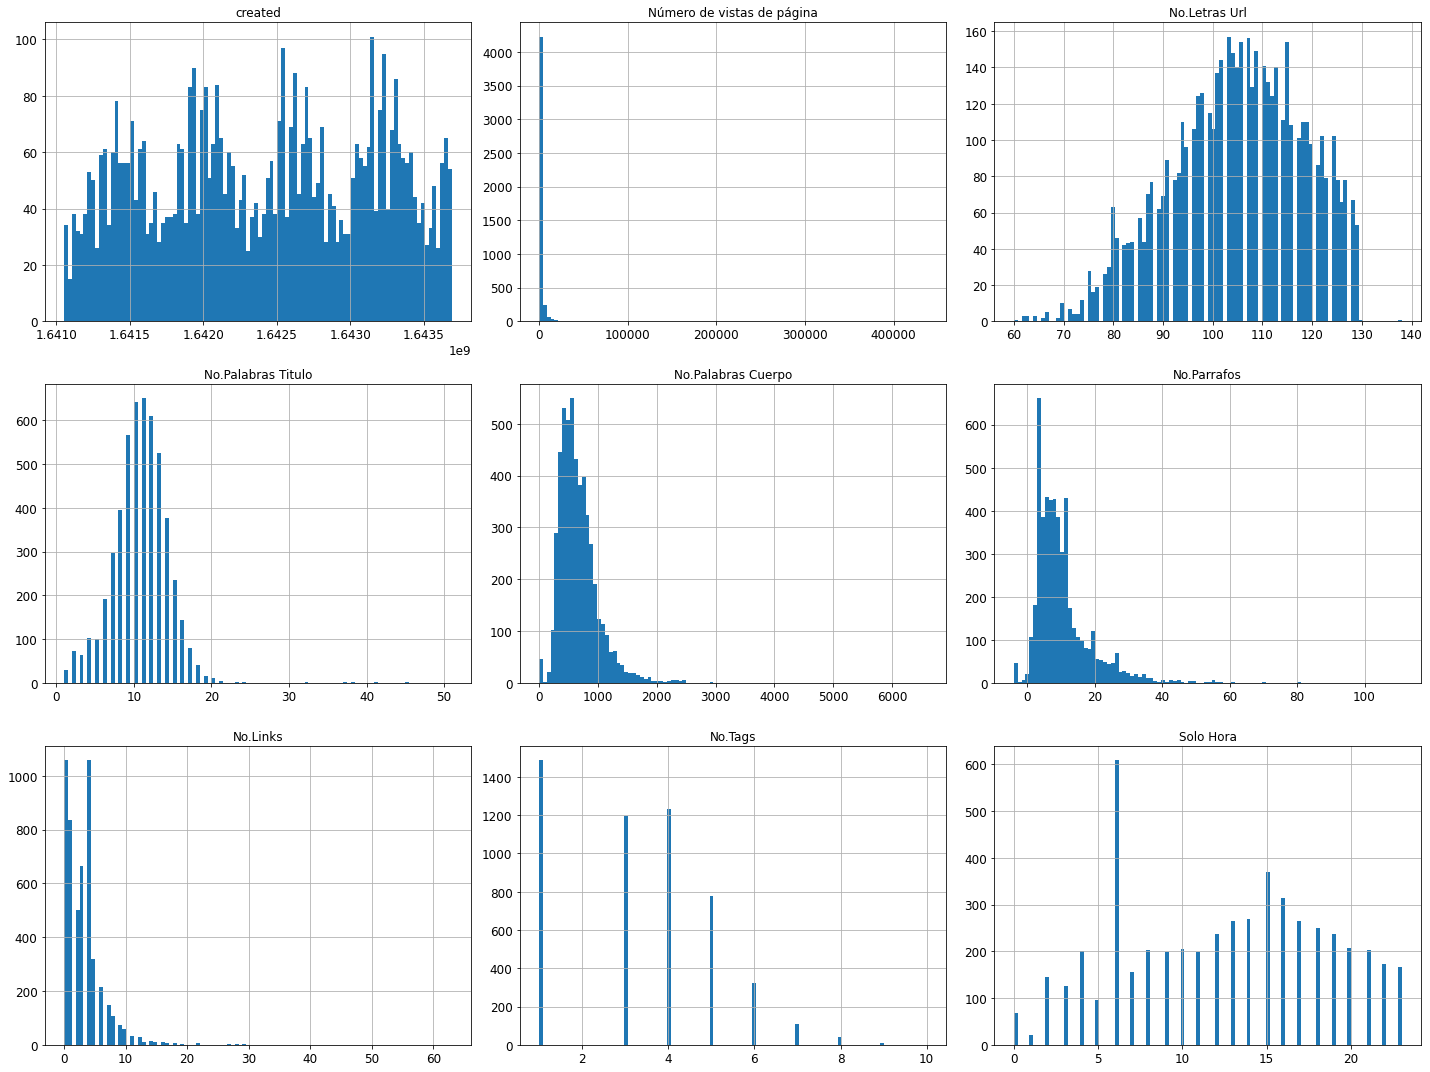

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
dfnotas.hist(bins=100, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [179]:
dfnotas
corr_matrix = dfnotas.corr()
corr_matrix['Número de vistas de página'].sort_values(ascending=False)

Número de vistas de página    1.000000
No.Palabras Cuerpo            0.015561
No.Links                     -0.001918
No.Palabras Titulo           -0.030889
No.Parrafos                  -0.032651
No.Letras Url                -0.044480
No.Tags                      -0.047679
id                           -0.116856
created                      -0.406674
Name: Número de vistas de página, dtype: float64

Saving figure attribute_histogram_plots


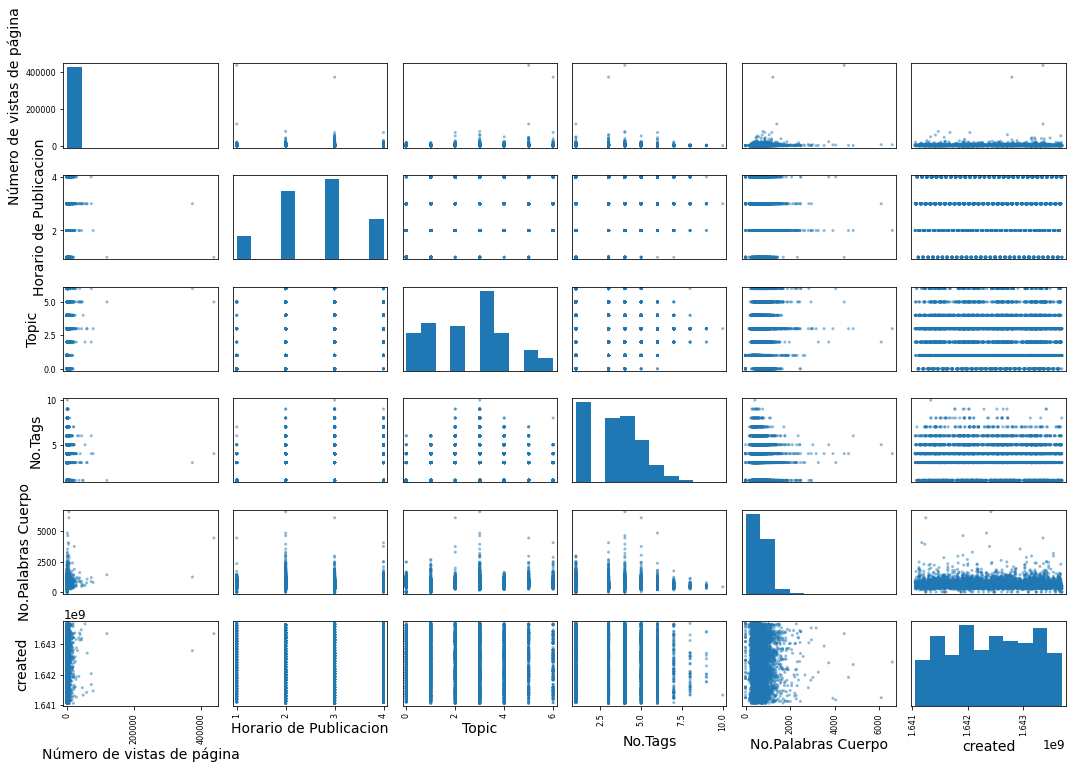

In [138]:
from pandas.plotting import scatter_matrix

attributes = ["Número de vistas de página", "Horario de Publicacion","Topic","No.Tags","No.Palabras Cuerpo","created"]
scatter_matrix(dfnotas[attributes], figsize=(15, 10))
save_fig("attribute_histogram_plots")

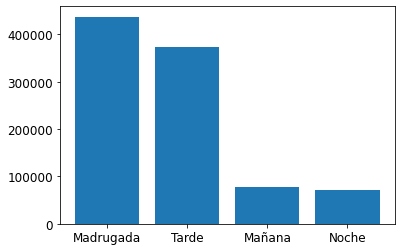

In [130]:
plt.bar( dfnotas['Horario de Publicacion'], dfnotas['Número de vistas de página'])
plt.show()


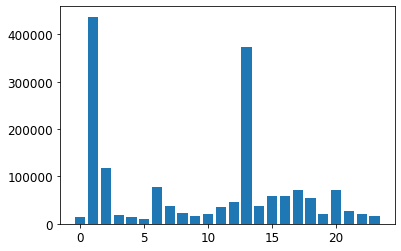

In [131]:
plt.bar( dfnotas['Solo Hora'], dfnotas['Número de vistas de página'])
plt.show()


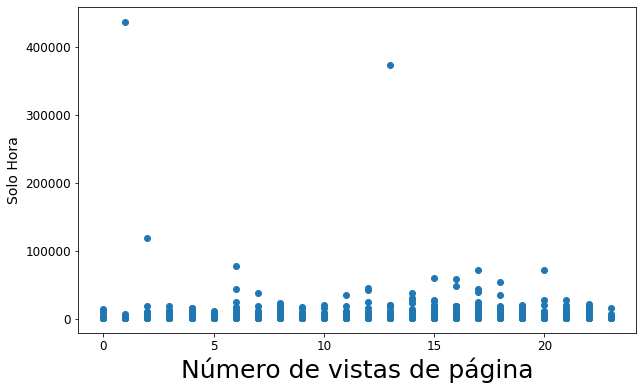

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))

x_values = dfnotas["Solo Hora"].unique()

ax.scatter(x = dfnotas["Solo Hora"], y = dfnotas["Número de vistas de página"])
plt.xlabel("Número de vistas de página",fontsize=25)
plt.ylabel("Solo Hora")

plt.show()

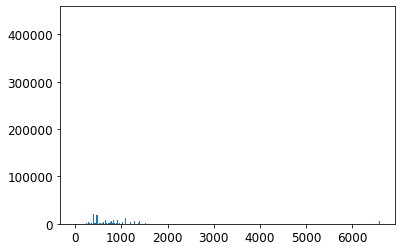

In [135]:
plt.bar( dfnotas['No.Palabras Cuerpo'], dfnotas['Número de vistas de página'])
plt.show()
